In [1]:
import os
import cv2
import glob
import numpy as np
from skimage import exposure
from datetime import datetime
from scipy.ndimage import convolve
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
import time
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import rasterio
from preprocessing import *

In [2]:
output_dir = 'Slumgullion'
method = 'cross_corr' # cross_corr, optical_flow

In [ ]:
preprocess_params = {
    "method": method,  
}

# Open the composite image and process each band
with rasterio.open(f'{output_dir}/S2_Composite_Filtered_8bit.tif') as src:
    num_bands = src.count
    print(f"Number of bands in the composite: {num_bands}")

    # Read the entire stack in the default Rasterio shape: (bands, height, width)
    orig = src.read()

# Preprocess the transposed stack (height, width, bands)
preprocessed_stack = preprocess_image_stack(orig, preprocess_params)

# Transpose the stack for visualization
orig = np.transpose(orig, (1, 2, 0))  # Shape: (height, width, bands)
print(f"Original stack shape: {orig.shape}")
print(f"Preprocessed stack shape: {preprocessed_stack.shape}")

In [ ]:
import matplotlib.pyplot as plt

# Define the number of images to display
num_images = 5

# Create subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, 2 * num_images))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(orig[:, :, i], cmap='gray')
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')
    
    # Processed image
    axes[i, 1].imshow(preprocessed_stack[:, :, i], cmap='gray')
    axes[i, 1].set_title(f'Processed Image {i+1}')
    axes[i, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Create a mask where 1 indicates that any pixel across the stack has a 0 in at least one image
zero_mask = np.any(orig == 0, axis=2).astype(int)

# Apply the mask to each image in the stack (setting 0 to NaN in masked areas)
orig_masked = np.where(zero_mask[..., np.newaxis] == 1, np.nan, orig)

# Display the mask for reference (optional)
plt.imshow(zero_mask, cmap='gray')
plt.title("Water Mask")
plt.axis('off')
plt.show()

In [ ]:
min_separation = 1 # in years
max_separation = 5 # in years

metadata_path = f"{output_dir}/Updated_Metadata.csv"

dat1, dat2, separation, datax = define_date_pairs(metadata_path, min_separation=min_separation, max_separation=max_separation)

## Feature Tracking ##

In [ ]:
from offset_track import *

# Extract images
img1 = preprocessed_stack[:, :, 1]
img2 = preprocessed_stack[:, :, 25]

# FT parameters
method = 'block_matching' # block_matching, optical_flow
match_func = 'fft_ncc' # fft_ncc, phase_cross_corr, mean_optical_flow
block_size = 16
overlap = 0.5

# Compute minimum and maximum displacement
subpixel_precision = 0.1  # Typical subpixel precision for match_template
max_displacement = block_size - 1  # Maximum displacement limited by block size

# Filter parameters
filter_params = {
    "apply_magnitude_filter": True,
    "min_magnitude": subpixel_precision,  # Automatically set based on subpixel precision
    "max_magnitude": 3,  # Maximum displacement limited by block size
    "apply_zero_mask_filter": False,
    "apply_deviation_filter": False,  # Enable filtering by deviation from mean
    "std_factor": 2.5,  # Allow deviation within n standard deviations
    "apply_remove_median_displacement": True,  # Remove the overall median displacement
    "apply_median_filter_step": False,  # Disable post-filtering with a median filter
    "filter_size": 5,  # Use a 5x5 median filter if enabled
    "apply_angular_coherence_filter": False,  # Enable angular coherence filtering
    "angular_threshold": 50,  # Angular threshold (degrees)
    "smoothing_sigma": 1,  # Smoothing parameter for angular coherence
    "apply_erratic_displacement_filter": False,  # Enable erratic displacement filtering
    "neighborhood_size": 20,  # Neighborhood size for erratic displacement filtering
    "deviation_threshold": 2.0,  # Threshold for deviation from neighborhood median
    'apply_snr_filter': True,
    'snr_threshold': 1,
}


# Start time
start_time = time.time()

# Call displacement_analysis with custom filter parameters
u, v, feature_points, max_corr, snr = displacement_analysis(
    img1=img1,
    img2=img2,
    method=method,
    block_size=block_size,
    overlap=overlap,
    match_func=match_func,
    zero_mask=zero_mask,
    filter_params=filter_params,  # Pass the custom filter parameters
    plot=True,
    arrow_scale=0.1
)

full_feature_points = feature_points # Save the full grid

# End time
end_time = time.time()

# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print(f"BLOCK MATCHING - Process completed in {elapsed_time:.2f} seconds. 1 Pair")

# Run for all pairs

In [ ]:
# FT parameters
method = 'block_matching' # block_matching, optical_flow
match_func = 'fft_ncc' # fft_ncc, phase_cross_corr, mean_optical_flow
block_size = 16
overlap = 0.1

# Compute minimum and maximum displacement
subpixel_precision = 0.1  # Typical subpixel precision for fft_ncc
max_displacement = block_size - 1  # Maximum displacement limited by block size

# Filter parameters
filter_params = {
    "apply_magnitude_filter": True,
    "min_magnitude": subpixel_precision,  # Automatically set based on subpixel precision
    "max_magnitude": 3,  # Maximum displacement limited by block size
    "apply_zero_mask_filter": False,
    "apply_deviation_filter": False,  # Enable filtering by deviation from mean
    "std_factor": 2.5,  # Allow deviation within n standard deviations
    "apply_remove_median_displacement": True,  # Remove the overall median displacement
    "apply_median_filter_step": False,  # Disable post-filtering with a median filter
    "filter_size": 5,  # Use a 5x5 median filter if enabled
    "apply_angular_coherence_filter": False,  # Enable angular coherence filtering
    "angular_threshold": 50,  # Angular threshold (degrees)
    "smoothing_sigma": 1,  # Smoothing parameter for angular coherence
    "apply_erratic_displacement_filter": False,  # Enable erratic displacement filtering
    "neighborhood_size": 20,  # Neighborhood size for erratic displacement filtering
    "deviation_threshold": 2.0,  # Threshold for deviation from neighborhood median
    'apply_snr_filter': True,
    'snr_threshold': 1,
}

# Run the processing function
results = process_image_pairs(
    dat1=dat1,
    dat2=dat2,
    datax=datax,
    preprocessed_stack=preprocessed_stack,
    zero_mask=zero_mask,
    filter_params=filter_params,
    method=method,
    block_size=block_size,
    overlap=overlap,
    match_func=match_func)

print('FINALLY DONE !')

### Handle the raw FT output here

In [3]:
from utils import *

# data = handle_predictions(
#     output_dir="Slumgullion_pcc",
#     method=method,
#     match_func=match_func,
#     results=results,
#     separation=separation,
#     orig=orig,
#     dat1=dat1,
#     dat2=dat2,
#     save=True,
#     load=True 
# )

# if you just open without running the block matching run this
data = handle_predictions(
    output_dir="Slumgullion_pcc",
    method="block_matching", # block_matching, optical_flow
    match_func="fft_ncc", # fft_ncc, phase_cross_corr, mean_optical_flow
    load=True  # Automatically loads if the file exists
)

Loaded data successfully from Slumgullion_pcc\Slumgullion_pcc_displacement_results_block_matching_fft_ncc.npz.


In [4]:
# Access variables
all_u = data['all_u']
all_v = data['all_v']
all_feature_points = data['all_feature_points']
all_max_corrs = data['all_max_corrs']
all_snrs = data['all_snrs']
separation = data['separation']
study_area_image = data['study_area_image']
dat1 = data['dat1']
dat2 = data['dat2']

# Filtering

### Final Filtering and Plotting

In [5]:
from postprocessing import *

# Resample morpho image to match `study_area_image` shape
morpho_path = f"{output_dir}/morpho.tif"
output_path = f"{output_dir}/resampled_morpho.tif"
resampled_morpho_path, resampled_transform = resample_morpho_to_match(study_area_image.shape, morpho_path, output_path)

# Open and plot the resampled DEM, slope, and aspect
with rasterio.open(resampled_morpho_path) as src:
    resampled_dem = src.read(1)  # Band 1: Resampled DEM
    resampled_slope = src.read(2)  # Band 2: Resampled slope
    resampled_aspect = src.read(3)  # Band 3: Resampled aspect

Plotting Median Displacement Field...


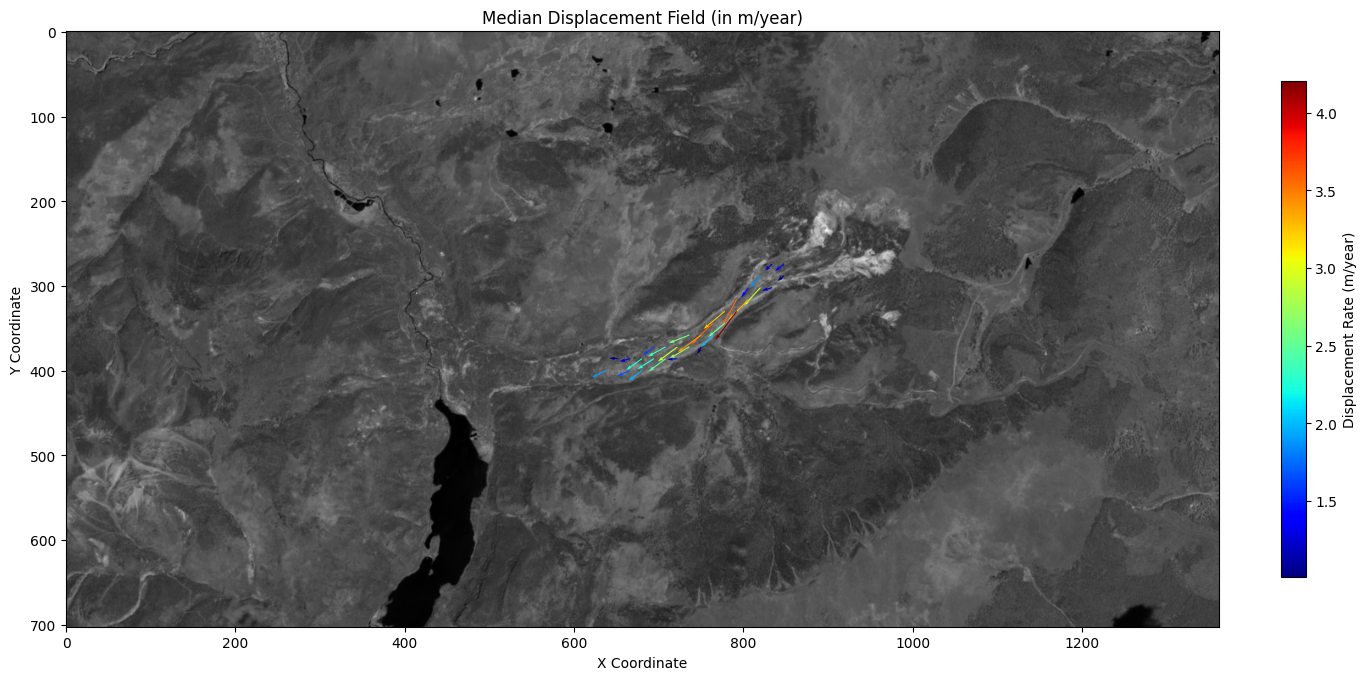

In [6]:
# Specify which filters to use & define parameters

pixel_size = 10                         # Pixel resolution in meters
min_displacement_threshold = 1          # Minimum reasonable displacement in m/year
max_displacement_threshold = 5        # Maximum reasonable displacement in m/year

use_angular_coherence = True            # Use angular coherence filter
angular_threshold_degrees = 30          # Angular threshold in degrees
use_slope_filter = True                 # Skip slope filter
min_slope_threshold = 5                 # Minimum slope in degrees
use_aspect_filter = False                # Use aspect filter
aspect_tolerance = 45                   # Allowable deviation from downslope direction in degrees
use_clustering = True                   # Skip clustering filter
clustering_params = (30, 5)             # Clustering parameters: (eps, min_samples)

arrow_scale = 0.1                       # Scale of the vector arrow

# Call the deployment function
median_feature_points, median_u, median_v, median_magnitude, displacement_data = deploy_displacement_analysis(
    all_u,                              # U-displacement components
    all_v,                              # V-displacement components
    all_feature_points,                 # Feature point coordinates
    separation,                         # Temporal separation between measurements
    resampled_slope,                    # Slope data for the study area
    resampled_aspect,                   # Aspect data for the study area
    study_area_image,                   # Image of the study area for visualization
    pixel_size=pixel_size, 
    min_displacement_threshold=min_displacement_threshold,
    max_displacement_threshold=max_displacement_threshold,
    angular_threshold_degrees=angular_threshold_degrees,
    min_slope_threshold=min_slope_threshold,
    aspect_tolerance=aspect_tolerance,
    smoothing_sigma=1,
    clustering_params=clustering_params,
    use_angular_coherence=use_angular_coherence,
    use_slope_filter=use_slope_filter,
    use_aspect_filter=use_aspect_filter,
    use_clustering=use_clustering,
    arrow_scale=arrow_scale
)

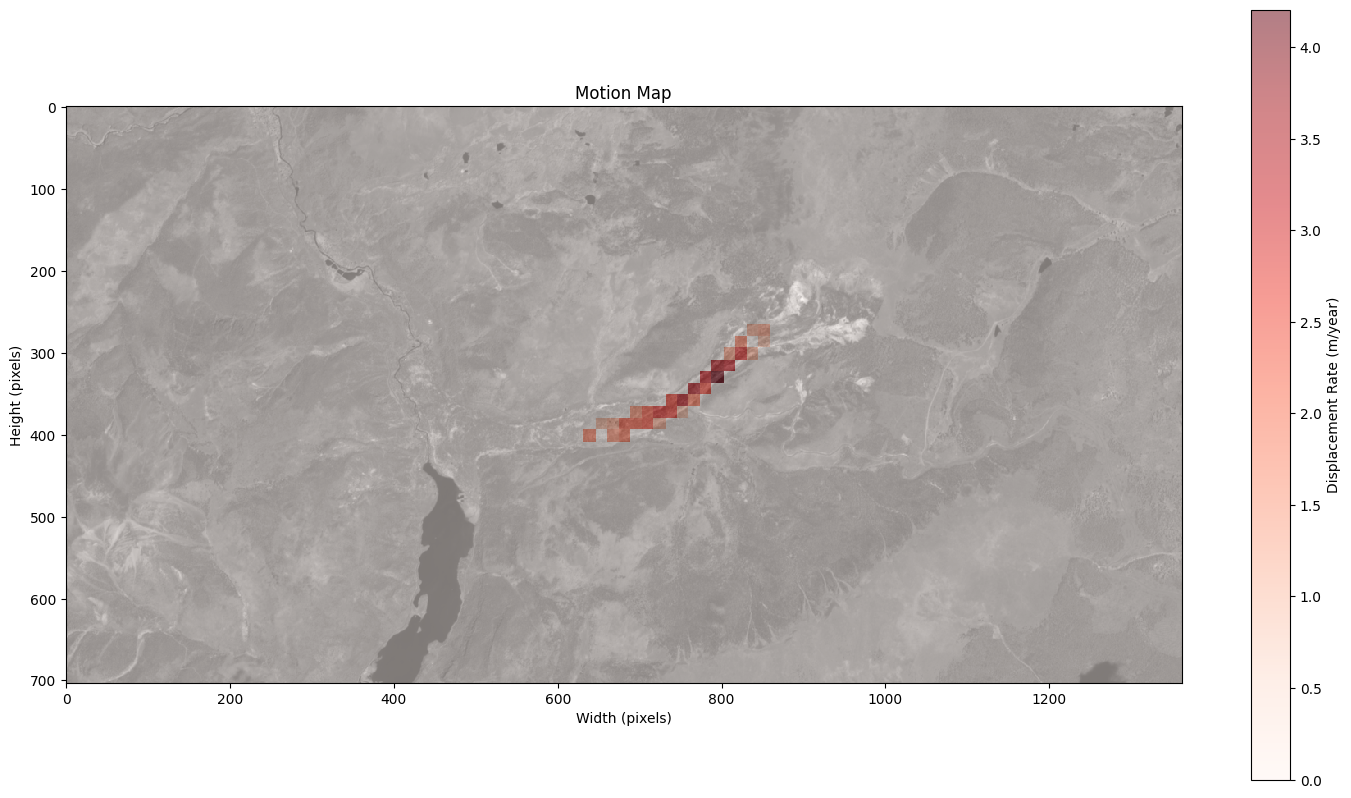

In [8]:
block_size = 16
overlap = 0.1
orig = f'{output_dir}/S2_Composite_Filtered_8bit.tif'
output_path = f"{output_dir}/output_motion_colormap.tif"


image_shape = study_area_image.shape

# Generate the magnitude map
magnitude_map = create_magnitude_map(image_shape, median_feature_points, median_magnitude, block_size, overlap)
overlay_magnitude_map(study_area_image, magnitude_map, block_size=block_size, overlap=overlap)
save_as_geotiff(orig, output_path, magnitude_map, block_size, overlap)

# Time Series Generation

In [32]:
def accumulate_displacement_with_placeholders(all_u, all_v, all_feature_points, separation, median_feature_points, dat1, dat2, pixel_size):
    """
    Accumulate displacements for each filtered feature point (median_feature_points) across all pairs,
    inserting NaN for missing intervals. Displacements are converted to meters using pixel size.
    Velocities are also computed for each interval.

    Parameters:
    - all_u: List of arrays containing u displacements in pixels.
    - all_v: List of arrays containing v displacements in pixels.
    - all_feature_points: List of arrays containing feature point coordinates.
    - separation: List of temporal separations for each pair (in years).
    - median_feature_points: Array of filtered feature points (reference grid).
    - dat1: Array of start dates for each interval.
    - dat2: Array of end dates for each interval.
    - pixel_size: Size of one pixel in meters.

    Returns:
    - displacement_data: Dictionary with aligned u_values, v_values, years_diff, dat1, dat2,
      u_velocity, and v_velocity for filtered points.
    """

    # Ensure points are consistently tuples
    median_feature_points = [tuple(fp) for fp in median_feature_points]

    # Initialize the data structure for filtered points only
    displacement_data = {tuple(fp): {
        'u_values': np.full(len(dat1), np.nan),
        'v_values': np.full(len(dat1), np.nan),
        'years_diff': np.full(len(dat1), np.nan),
        'dat1': [None] * len(dat1),
        'dat2': [None] * len(dat1),
        'u_velocity': np.full(len(dat1), np.nan),
        'v_velocity': np.full(len(dat1), np.nan),
    } for fp in median_feature_points}

    # Debugging: Ensure all arrays have matching lengths
    if not (len(all_u) == len(all_v) == len(all_feature_points) == len(separation) == len(dat1) == len(dat2)):
        raise ValueError("Input lists must have the same length")

    # Loop over all intervals
    for i in range(len(all_u)):
        u, v, feature_points, year_diff = all_u[i], all_v[i], all_feature_points[i], separation[i]

        # Convert feature points to tuples for consistency
        feature_points = [tuple(fp) for fp in feature_points]

        for j, point in enumerate(feature_points):
            if point in displacement_data:  # Only consider filtered points
                # Convert displacements to meters using pixel size
                u_meters = u[j] * pixel_size
                v_meters = v[j] * pixel_size
                displacement_data[point]['u_values'][i] = -u_meters
                displacement_data[point]['v_values'][i] = -v_meters
                displacement_data[point]['years_diff'][i] = year_diff
                displacement_data[point]['dat1'][i] = dat1[i]
                displacement_data[point]['dat2'][i] = dat2[i]

                # Calculate velocities (m/year) if year_diff is valid
                if not np.isnan(year_diff) and year_diff > 0:
                    u_velocity = u_meters / year_diff
                    v_velocity = v_meters / year_diff
                    displacement_data[point]['u_velocity'][i] = u_velocity
                    displacement_data[point]['v_velocity'][i] = v_velocity
                    
    return displacement_data

# Example usage (ensure to define the input variables):
displacement_data = accumulate_displacement_with_placeholders(
    all_u, all_v, all_feature_points, separation, median_feature_points, dat1, dat2, pixel_size
)

# Method 1: middle date, monthly/yearly median

In [ ]:
import pandas as pd

def create_velocity_time_series(displacement_data, interval='monthly'):
    """
    Create velocity time series for each point by assigning velocities to the midpoint date
    between dat1 and dat2.

    Parameters:
    - displacement_data: Dictionary with 'dat1', 'dat2', 'u_velocities', and 'v_velocities' for each point.
    - interval: Aggregation interval ('daily', 'monthly', 'yearly').

    Returns:
    - midpoint_dfs: Dictionary of midpoint DataFrames for each point.
    """
    midpoint_dfs = {}

    for point, data in displacement_data.items():
        # Initialize an empty list to store midpoint velocities
        midpoint_data = []

        # Extract data for the point
        dat1 = data['dat1']
        dat2 = data['dat2']
        u_velocities = data['u_velocity']
        v_velocities = data['v_velocity']

        # Populate midpoint velocities for each interval
        for start, end, u_vel, v_vel in zip(dat1, dat2, u_velocities, v_velocities):
            if not np.isnan(u_vel) and not np.isnan(v_vel):
                # Calculate the midpoint date
                start_date = pd.Timestamp(start)
                end_date = pd.Timestamp(end)
                midpoint_date = start_date + (end_date - start_date) / 2

                # Append the midpoint velocity data
                midpoint_data.append({'date': midpoint_date, 'u_velocity': u_vel, 'v_velocity': v_vel})

        # Convert midpoint data to a DataFrame
        midpoint_df = pd.DataFrame(midpoint_data)

        # Store the midpoint DataFrame for this point
        midpoint_dfs[point] = midpoint_df

    return midpoint_dfs


# Example Usage
# Assuming `displacement_data` is defined
midpoint_dfs = create_velocity_time_series(displacement_data, interval='monthly')

# Print midpoint data for each point
for point, df in midpoint_dfs.items():
    print(f"Midpoint Data for Point {point}:")
    print(df)


In [ ]:
def resample_velocity_time_series(midpoint_dfs, interval='monthly'):
    """
    Resample the midpoint velocity data for each point by aggregating it monthly or yearly.

    Parameters:
    - midpoint_dfs: Dictionary of DataFrames containing midpoint velocity data for each point.
    - interval: Aggregation interval ('monthly' or 'yearly').

    Returns:
    - resampled_dfs: Dictionary of resampled DataFrames for each point.
    """
    resampled_dfs = {}

    for point, df in midpoint_dfs.items():
        # Ensure 'date' is the index for resampling
        df.set_index('date', inplace=True)

        if interval == 'monthly':
            # Resample by month and aggregate using the mean
            resampled_df = df.resample('ME').median().reset_index()
        elif interval == 'yearly':
            # Resample by year and aggregate using the mean
            resampled_df = df.resample('Y').median().reset_index()
        else:
            raise ValueError("Interval must be 'monthly' or 'yearly'.")

        # Store the resampled DataFrame for this point
        resampled_dfs[point] = resampled_df

    return resampled_dfs


# Example Usage
# Assuming `midpoint_dfs` is the output from `create_velocity_time_series`
resampled_dfs = resample_velocity_time_series(midpoint_dfs, interval='monthly')

# Print resampled data for each point
for point, df in resampled_dfs.items():
    print(f"Resampled Data for Point {point}:")
    print(df)


In [ ]:
def prepare_csv_with_components(updated_dfs):
    """
    Prepare two CSVs in EGMS-like format using velocity time series for each component (u and v).
    Include a 'point' column with image coordinates as tuples, a 'median_velocity_u' and 'median_velocity_v' column,
    and format dates to 'YYYYMMDD'.

    Parameters:
    - updated_dfs: Dictionary of DataFrames containing time series data for each point, including u and v components.

    Returns:
    - formatted_csv_u: A Pandas DataFrame for the u-component, ready for CSV export.
    - formatted_csv_v: A Pandas DataFrame for the v-component, ready for CSV export.
    """
    # Initialize the lists for storing all points' data for u and v components
    csv_data_u = []
    csv_data_v = []

    # Loop through each point and its corresponding DataFrame
    for point, df in updated_dfs.items():
        # Convert point to plain numbers
        point = tuple(map(int, point))

        # Format dates in the required format YYYYMMDD
        df['formatted_date'] = df['date'].dt.strftime('%Y%m%d')
        # print(df)
        
        # Flatten the time series into dictionaries for u and v components
        time_series_u = df.set_index('formatted_date')['u_velocity'].to_dict()
        time_series_v = df.set_index('formatted_date')['v_velocity'].to_dict()
        
        # Limit decimal precision to 1 after the comma for u and v values
        time_series_u = {k: (round(v, 1) if isinstance(v, (int, float)) else v) for k, v in time_series_u.items()}
        time_series_v = {k: (round(v, 1) if isinstance(v, (int, float)) else v) for k, v in time_series_v.items()}
        
        median_velocity_u = round(df['u_velocity'].median(), 1)
        median_velocity_v = round(df['v_velocity'].median(), 1)

        # Prepare the row for the u-component
        row_u = {
            'point': point,                   # Save the point as plain numbers
            'median_velocity_EW': median_velocity_u  # Add the median velocity for u
        }
        row_u.update(time_series_u)  # Add time series data for u
        csv_data_u.append(row_u)

        # Prepare the row for the v-component
        row_v = {
            'point': point,                   # Save the point as plain numbers
            'median_velocity_SN': median_velocity_v  # Add the median velocity for v
        }
        row_v.update(time_series_v)  # Add time series data for v
        csv_data_v.append(row_v)

    # Convert the lists of dictionaries to DataFrames
    formatted_csv_u = pd.DataFrame(csv_data_u)
    formatted_csv_v = pd.DataFrame(csv_data_v)

    return formatted_csv_u, formatted_csv_v

# Create velocity time series CSVs with median velocities for u and v components
csv_data_u, csv_data_v = prepare_csv_with_components(resampled_dfs)

# Save to CSV (optional)
csv_data_u.to_csv(f'{output_dir}/velocity_time_series_EW.csv', index=False)
csv_data_v.to_csv(f'{output_dir}/velocity_time_series_SN.csv', index=False)

# Display the result
csv_data_u.head(), csv_data_v.head()

In [ ]:
import matplotlib.pyplot as plt

def plot_fastest_points_components(csv_data_u, csv_data_v, top_n=5):
    """
    Plot the time series of the fastest points based on median velocity for both u and v components,
    showing both components for the same point on the same plot.

    Parameters:
    - csv_data_u: Pandas DataFrame containing u-component time series data and median velocity.
    - csv_data_v: Pandas DataFrame containing v-component time series data and median velocity.
    - top_n: Number of fastest points to plot for each component.
    """
    # Sort the data by median_velocity_u in descending order (assuming top points are the same for u and v components)
    fastest_points_u = csv_data_u.sort_values(by='median_velocity_EW', ascending=False).head(top_n)

    for _, row_u in fastest_points_u.iterrows():
        point = row_u['point']
        median_velocity_u = row_u['median_velocity_EW']

        # Find corresponding row in v-component DataFrame
        row_v = csv_data_v[csv_data_v['point'] == point].iloc[0]
        median_velocity_v = row_v['median_velocity_SN']

        # Extract the time series data (filter out non-date columns)
        time_series_u = row_u.drop(['point', 'median_velocity_EW']).dropna()
        time_series_v = row_v.drop(['point', 'median_velocity_SN']).dropna()

        dates_u = pd.to_datetime(time_series_u.index, format='%Y%m%d')
        values_u = time_series_u.values

        dates_v = pd.to_datetime(time_series_v.index, format='%Y%m%d')
        values_v = time_series_v.values

        # Plot the time series for u and v components
        plt.figure(figsize=(12, 6))
        plt.scatter(dates_u, values_u, label=f'EW-Component (Median Velocity: {median_velocity_u:.2f} m/year)', marker='o')
        plt.scatter(dates_v, values_v, label=f'SN-Component (Median Velocity: {median_velocity_v:.2f} m/year)', marker='x')
        plt.title(f'Time Series for Point {point}')
        plt.xlabel('Date')
        plt.ylabel('Displacement (m/year)')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

plot_fastest_points_components(csv_data_u, csv_data_v, top_n=5)

In [ ]:
import rasterio
import pandas as pd
import random
import string

def prepare_csv_with_components(updated_dfs, geotiff_path):
    """
    Prepare two CSVs in EGMS-like format using velocity time series for each component (EW and SN).
    Include a 'pid', 'latitude', 'longitude', 'easting', and 'northing' columns (EPSG:4326),
    along with median velocities and time series data formatted as 'YYYYMMDD'.

    Parameters:
    - updated_dfs: Dictionary of DataFrames containing time series data for each point, including EW and SN components.
    - geotiff_path: Path to the GeoTIFF file used for georeferencing image coordinates.

    Returns:
    - formatted_csv_ew: A Pandas DataFrame for the EW component, ready for CSV export.
    - formatted_csv_sn: A Pandas DataFrame for the SN component, ready for CSV export.
    """
    # Open the GeoTIFF file to get geotransform
    with rasterio.open(geotiff_path) as src:
        transform = src.transform

    def image_to_georef(x, y):
        """Convert image coordinates (col, row) to georeferenced coordinates."""
        lon, lat = rasterio.transform.xy(transform, y, x, offset='center')
        return round(lon, 6), round(lat, 6)  # Round to 6 decimals for precision

    def generate_pid():
        """Generate a random alphanumeric PID."""
        return 'OT' + ''.join(random.choices(string.ascii_letters + string.digits, k=8))

    # Initialize the lists for storing all points' data for EW and SN components
    csv_data_ew = []
    csv_data_sn = []

    # Loop through each point and its corresponding DataFrame
    for point, df in updated_dfs.items():
        # Convert point to georeferenced coordinates
        lon, lat = image_to_georef(*point)
        pid = generate_pid()

        # Format dates in the required format YYYYMMDD
        df['formatted_date'] = df['date'].dt.strftime('%Y%m%d')
        
        # Flatten the time series into dictionaries for EW and SN components
        time_series_ew = df.set_index('formatted_date')['u_velocity'].to_dict()
        time_series_sn = df.set_index('formatted_date')['v_velocity'].to_dict()
        
        # Limit decimal precision to 1 after the comma for EW and SN values
        time_series_ew = {k: (round(v, 1) if isinstance(v, (int, float)) else v) for k, v in time_series_ew.items()}
        time_series_sn = {k: (round(v, 1) if isinstance(v, (int, float)) else v) for k, v in time_series_sn.items()}
        
        median_velocity_ew = round(df['u_velocity'].median(), 1)
        median_velocity_sn = round(df['v_velocity'].median(), 1)

        # Prepare the row for the EW component
        row_ew = {
            'pid': pid,                      # Unique alphanumeric identifier for the point
            'latitude': lat,                 # Latitude in EPSG:4326
            'longitude': lon,                # Longitude in EPSG:4326
            'easting': point[0],             # Image X-coordinate
            'northing': point[1],            # Image Y-coordinate
            'median_velocity': median_velocity_ew  # Add the median velocity for EW
        }
        row_ew.update(time_series_ew)  # Add time series data for EW
        csv_data_ew.append(row_ew)

        # Prepare the row for the SN component
        row_sn = {
            'pid': pid,                      # Unique alphanumeric identifier for the point
            'latitude': lat,                 # Latitude in EPSG:4326
            'longitude': lon,                # Longitude in EPSG:4326
            'easting': point[0],             # Image X-coordinate
            'northing': point[1],            # Image Y-coordinate
            'median_velocity': median_velocity_sn  # Add the median velocity for SN
        }
        row_sn.update(time_series_sn)  # Add time series data for SN
        csv_data_sn.append(row_sn)

    # Convert the lists of dictionaries to DataFrames
    formatted_csv_ew = pd.DataFrame(csv_data_ew)
    formatted_csv_sn = pd.DataFrame(csv_data_sn)

    return formatted_csv_ew, formatted_csv_sn

# Create velocity time series CSVs with median velocities for EW and SN components
csv_data_ew, csv_data_sn = prepare_csv_with_components(resampled_dfs, geotiff_path=f'{output_dir}/S2_Composite_Filtered_8bit.tif')

# Save to CSV (optional)
csv_data_ew.to_csv(f'{output_dir}/velocity_time_series_ew.csv', index=False)
csv_data_sn.to_csv(f'{output_dir}/velocity_time_series_sn.csv', index=False)

# Display the result
csv_data_ew.head(), csv_data_sn.head()

In [38]:
# import numpy as np

# def compute_rmse(velocities, reference='median'):
#     """
#     Compute RMSE for a velocity time series.

#     Parameters:
#     - velocities: List or array of velocity values.
#     - reference: 'mean' or 'median' to specify the reference value.

#     Returns:
#     - RMSE value.
#     """
#     velocities = np.array(velocities)
#     if reference == 'median':
#         ref_value = np.median(velocities)
#     elif reference == 'mean':
#         ref_value = np.mean(velocities)
#     else:
#         raise ValueError("Reference must be 'mean' or 'median'.")

#     residuals = velocities - ref_value
#     rmse = np.sqrt(np.mean(residuals**2))
#     return rmse

# # Example usage:
# time_series_velocities = [0.5, 0.6, 0.7, 0.8, 0.6]  # Example velocity time series
# rmse_value = compute_rmse(time_series_velocities, reference='median')
# print("RMSE:", rmse_value)


In [ ]:
import matplotlib.pyplot as plt
import rasterio
import pandas as pd

# Paths to input files
geotiff_path = f'{output_dir}/S2_Composite_Filtered_8bit.tif'
csv_ew_path = f'{output_dir}/velocity_time_series_ew.csv'
csv_sn_path = f'{output_dir}/velocity_time_series_sn.csv'

# Load CSVs
csv_data_ew = pd.read_csv(csv_ew_path)
csv_data_sn = pd.read_csv(csv_sn_path)

# Combine EW and SN velocities into a single DataFrame
csv_data_ew['mean_velocity'] = (csv_data_ew['median_velocity']**2 + csv_data_sn['median_velocity']**2)**0.5
csv_data_ew['longitude'] = csv_data_ew['longitude']
csv_data_ew['latitude'] = csv_data_ew['latitude']

# Load GeoTIFF image
with rasterio.open(geotiff_path) as src:
    image = src.read(1)  # Read the first band
    transform = src.transform

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(image, cmap='gray', extent=[
    transform[2],  # Left (xmin)
    transform[2] + transform[0] * image.shape[1],  # Right (xmax)
    transform[5] + transform[4] * image.shape[0],  # Bottom (ymin)
    transform[5]  # Top (ymax)
])
# plt.colorbar(label='Image Intensity')
plt.title('Mean Velocity Overlaid on Image')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Overlay mean velocity as scatter points
scatter = plt.scatter(
    csv_data_ew['longitude'], csv_data_ew['latitude'],
    c=csv_data_ew['mean_velocity'], cmap='coolwarm', s=15, edgecolor='k', alpha=0.7
)
plt.colorbar(scatter, label='Mean Velocity (m/year)')
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
def process_displacement_to_intervals(displacement_data, dat1, dat2, interval='monthly', return_daily=False):
    """
    Process resultant velocity data into cumulative intervals with median handling of overlaps.

    The function normalizes velocity data to a daily series, handles overlapping days by 
    computing the median of daily contributions, and aggregates the values to a specified 
    interval ('daily', 'monthly', 'yearly').

    Parameters:
    - displacement_data: Dictionary where keys are point IDs and values include:
      'resultant_velocities' (velocity in m/year) and 'years_diff' (duration of each interval).
    - dat1: Array of start dates for each interval.
    - dat2: Array of end dates for each interval.
    - interval: Interval for aggregation ('daily', 'monthly', 'yearly').
    - return_daily: If True, returns the daily time series without aggregation.

    Returns:
    - aggregated_series: Dictionary of cumulative velocity for each interval (median for 
      intervals, daily medians for daily), or a Pandas DataFrame of the daily time series if `return_daily` is True.
    """
    from datetime import timedelta
    from collections import defaultdict
    import numpy as np
    import pandas as pd

    # Step 1: Normalize to daily series by assigning velocity directly
    daily_series = defaultdict(lambda: defaultdict(list))  # Dictionary to store daily contributions for each point

    # Loop over each displacement point
    for point, data in displacement_data.items():
        resultant_velocities = data['resultant_velocities']
        years_diff = data['years_diff']

        # Iterate over each velocity (for each point, there may be multiple intervals)
        for resultant, start, end in zip(resultant_velocities, dat1, dat2):
            if np.isnan(resultant) or start is None or end is None:
                continue  # Skip invalid or NaN values

            current_date = start  # Start from the beginning of the displacement period
            while current_date < end:
                daily_series[point][current_date].append(resultant)  # Assign velocity directly
                current_date += timedelta(days=1)  # Move to the next day

    # Step 2: Compute daily medians for overlapping velocities
    daily_medians = defaultdict(dict)  # Dictionary to store daily medians for each point

    for point, daily_contributions in daily_series.items():
        for date, contributions in daily_contributions.items():
            median_value = np.nanmean(contributions)  # Compute the median
            daily_medians[point][date] = median_value

    # Convert daily medians into a Pandas DataFrame
    all_data = []
    for point, daily_values in daily_medians.items():
        for date, value in daily_values.items():
            all_data.append({'point': point, 'date': date, 'velocity': value})

    df = pd.DataFrame(all_data)

    # Ensure 'date' is a datetime object
    df['date'] = pd.to_datetime(df['date'])

    # Sort by point and date for easier visualization
    df = df.sort_values(by=['point', 'date'])

    # Return the daily time series if requested
    if return_daily:
        return df

    # Step 3: Aggregate to the specified intervals (cumulative median)
    if interval == 'daily':
        return daily_medians  # Return daily medians directly if 'daily' is requested

    # Define how to group days into intervals (e.g., monthly or yearly)
    interval_key = {
        'monthly': lambda d: (d.year, d.month),  # Group by year and month
        'yearly': lambda d: d.year  # Group by year
    }[interval]

    # Initialize lists for contributions to each interval
    interval_values = defaultdict(lambda: defaultdict(list))

    # Loop through the daily medians and collect values for each interval
    for point, daily_values in daily_medians.items():
        for date, value in daily_values.items():
            key = interval_key(date)  # Determine the interval key (e.g., (year, month) for monthly)
            interval_values[point][key].append(value)  # Collect daily values for this interval

    # Compute the median for each interval
    aggregated_intervals = defaultdict(dict)
    for point, intervals in interval_values.items():
        for key, values in intervals.items():
            aggregated_intervals[point][key] = np.nanmedian(values)  # Compute the median, ignoring NaN values

    return aggregated_intervals

In [ ]:
# Daily time series
# daily_ts = process_displacement_to_intervals(displacement_data, dat1, dat2, return_daily=True)
# print(daily_ts)

# Aggregated yearly data
aggregated = process_displacement_to_intervals(displacement_data, dat1, dat2, interval='monthly')
print(aggregated)

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Plot the Study Area Image with Fast-Moving Points Highlighted
def plot_fast_moving_points_on_image(fast_points, study_area_image):
    """
    Plot the study area image with fast-moving points highlighted.

    Args:
        fast_points (np.ndarray): Array of fast-moving points with (x, y) coordinates.
        study_area_image (np.ndarray): Image of the study area.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(study_area_image, cmap='gray')
    plt.scatter(fast_points[:, 0], fast_points[:, 1], color='red', s=50, label='Fast-Moving Points')
    plt.title("Fast-Moving Points Over Study Area")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(False)
    plt.show()

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import datetime

def plot_processed_resultant(processed_resultant, interval='monthly'):
    """
    Plot the processed resultant displacements or velocities for each point.

    Parameters:
    - processed_resultant: Dictionary of processed displacements or velocities for each point.
    - interval: The interval for the processed data ('daily', 'monthly', 'yearly').
    """
    for point, data in processed_resultant.items():
        # Convert keys to datetime objects
        if interval == 'monthly':
            dates = [datetime(year, month, 1) for year, month in data.keys()]  # First day of each month
        elif interval == 'yearly':
            dates = [datetime(year, 1, 1) for year in data.keys()]  # First day of each year
        else:
            raise ValueError("Unsupported interval: choose 'monthly' or 'yearly'.")

        displacements = list(data.values())

        # Create the plot for each point
        plt.figure(figsize=(12, 6))
        plt.plot(dates, displacements, label=f'Point {point}', marker='o', linestyle='-')
        plt.title(f'{interval.capitalize()} Resultant Displacement for Point {point}')
        plt.xlabel('Date')
        plt.ylabel('Displacement (m/year)')
        plt.xticks(rotation=45)

        # Format the x-axis dates dynamically
        if interval == 'monthly':
            plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))  # Format as "Month Year"
        elif interval == 'yearly':
            plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))  # Format as "Year"

        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

plot_fast_moving_points_on_image(median_feature_points, study_area_image)
plot_processed_resultant(aggregated)

In [135]:
import matplotlib.dates as mdates
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np 

# Threshold for identifying fast-moving points
MIN_VEL_THRESH = 1  # m/year
MAX_VEL_THRESH = 5

# Identify fast-moving points
fast_indices = np.where((median_magnitude > MIN_VEL_THRESH) & (median_magnitude < MAX_VEL_THRESH))[0]
fast_points = median_feature_points[fast_indices]

In [144]:
def plot_displacement_time_series(filtered_u, filtered_v, dat1, dat2, fast_points, max_plots=5):
    """
    Plot normalized displacement velocities as horizontal lines for fast-moving points.

    Parameters:
    - filtered_u: Dictionary of `u` displacement values keyed by (x, y).
    - filtered_v: Dictionary of `v` displacement values keyed by (x, y).
    - dat1: Array of start dates as datetime objects.
    - dat2: Array of end dates as datetime objects.
    - fast_points: Array of fast-moving points (x, y) to plot.
    - max_plots: Maximum number of points to plot (default is 5).
    """
    plt.figure(figsize=(10, 6))

    for idx, point in enumerate(fast_points[:max_plots]):
        x, y = point

        # Ensure the point exists in filtered data
        if (x, y) not in filtered_u or (x, y) not in filtered_v:
            print(f"Point ({x}, {y}) not found in filtered data. Skipping...")
            continue

        u_values = filtered_u[(x, y)]
        v_values = filtered_v[(x, y)]

        if len(u_values) != len(dat1) or len(v_values) != len(dat2):
            print(f"Skipping point ({x}, {y}): Mismatched lengths between displacement and dates.")
            continue

        # Calculate years_diff (time intervals in years)
        years_diff = np.array([(end - start).days / 365.0 for start, end in zip(dat1, dat2)])

        # Normalize displacements by time to get velocities
        u_velocities = np.array(u_values) / years_diff
        v_velocities = np.array(v_values) / years_diff
        magnitudes = np.sqrt(u_velocities**2 + v_velocities**2)  # Velocity magnitudes

        # Plot each velocity as a horizontal line
        for i in range(len(years_diff)):
            plt.hlines(
                magnitudes[i],
                dat1[i],
                dat2[i],
                colors=f"C{idx}",
                label=f"Point ({x}, {y})" if i == 0 else ""
            )

        plt.scatter(dat2, magnitudes, color=f"C{idx}", marker='o')  # Mark the end of each period

    plt.title("Normalized Displacement Velocities for Fast-Moving Points")
    plt.xlabel("Time")
    plt.ylabel("Velocity (m/year)")
    plt.legend()
    plt.grid()

    # Format the x-axis for dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_displacement_time_series(filtered_u, filtered_v, dat1, dat2, fast_points, max_plots=5)


In [136]:
def aggregate_displacement_by_date(interpolated_u, interpolated_v, start_dates, end_dates):
    """
    Aggregate normalized displacement rates for each point grouped by end date.

    Args:
        interpolated_u (dict): Dictionary of u displacements indexed by (x, y).
        interpolated_v (dict): Dictionary of v displacements indexed by (x, y).
        dat1 (list): List of start dates for each interval.
        dat2 (list): List of end dates for each interval.

    Returns:
        tuple: (reduced_u, reduced_v), dictionaries of aggregated rates by end date.
    """
    # Nested defaultdict to handle (x, y) -> date -> list of values
    aggregated_u = defaultdict(lambda: defaultdict(list))
    aggregated_v = defaultdict(lambda: defaultdict(list))

    for (x, y), u_series in interpolated_u.items():
        v_series = interpolated_v[(x, y)]  # Assume the same keys for u and v
        for start_date, end_date, u, v in zip(dat1, dat2, u_series, v_series):
            time_lag = (end_date - start_date).days
            if time_lag > 0:  # Avoid division by zero
                rate_u = u / time_lag
                rate_v = v / time_lag
                aggregated_u[(x, y)][end_date].append(rate_u)
                aggregated_v[(x, y)][end_date].append(rate_v)

    # Reduce multiple rates to a single value per end date (median)
    reduced_u = {
        (x, y): {date: np.median(rates) for date, rates in date_map.items()}
        for (x, y), date_map in aggregated_u.items()
    }
    reduced_v = {
        (x, y): {date: np.median(rates) for date, rates in date_map.items()}
        for (x, y), date_map in aggregated_v.items()
    }

    return reduced_u, reduced_v

# interpolated_u and interpolated_v would be dictionaries indexed by (x, y) with lists of displacements
# dat2_start_dates and dat2_end_dates would be lists of datetime objects representing intervals
reduced_u, reduced_v = aggregate_displacement_by_date(interpolated_u, interpolated_v, dat1, dat2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Step 1: Plot the Study Area Image with Fast-Moving Points Highlighted
def plot_fast_moving_points_on_image(fast_points, study_area_image):
    """
    Plot the study area image with fast-moving points highlighted.

    Args:
        fast_points (np.ndarray): Array of fast-moving points with (x, y) coordinates.
        study_area_image (np.ndarray): Image of the study area.
    """
    plt.figure(figsize=(12, 12))
    plt.imshow(study_area_image, cmap='gray')
    plt.scatter(fast_points[:, 0], fast_points[:, 1], color='red', s=50, label='Fast-Moving Points')
    plt.title("Fast-Moving Points Over Study Area")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(False)
    plt.show()

# Step 2: Plot Cumulative Displacement for Selected Points
def plot_cumulative_displacement_for_fast_points(fast_points, reduced_u, reduced_v, dat1, dat2, max_plots=25):
    """
    Plot cumulative displacement magnitude time series for fast-moving points.

    Args:
        fast_points (np.ndarray): Array of fast-moving points with (x, y) coordinates.
        reduced_u (dict): Dictionary of u displacement rates indexed by (x, y).
        reduced_v (dict): Dictionary of v displacement rates indexed by (x, y).
        dat2_start_dates (np.ndarray): Array of datetime objects for start dates.
        dat2_end_dates (np.ndarray): Array of datetime objects for end dates.
        max_plots (int): Maximum number of points to plot.
    """
    # Ensure that start and end dates are arrays of the same length
    if len(dat1) != len(dat2):
        raise ValueError("Start dates and end dates must have the same length.")
    
    # Create a mapping from end date to (start_date, end_date)
    dat2_intervals = {end_date: (start_date, end_date) for start_date, end_date in zip(dat1, dat2)}

    for i, point in enumerate(fast_points[:max_plots]):
        # Extract the point's (x, y) coordinates
        x, y = point

        # Check if point exists in reduced displacement data
        if (x, y) in reduced_u and (x, y) in reduced_v:
            u_series = reduced_u[(x, y)]
            v_series = reduced_v[(x, y)]

            # Extract dates and displacements as sorted lists for plotting
            sorted_dates = sorted(u_series.keys())
            sorted_u = [u_series[date] for date in sorted_dates]
            sorted_v = [v_series[date] for date in sorted_dates]

            # Calculate cumulative displacement magnitude
            cumulative_displacement = []
            total_displacement = 0.0
            for idx, date in enumerate(sorted_dates):
                # Get the corresponding time interval
                if date not in dat2_intervals:
                    print(f"Date {date} not found in dat2_intervals. Skipping...")
                    continue

                start_date, end_date = dat2_intervals[date]
                time_lag = (end_date - start_date).days

                # Calculate displacement for the interval
                if time_lag > 0:
                    interval_displacement = np.sqrt(sorted_u[idx]**2 + sorted_v[idx]**2) * time_lag
                    total_displacement += interval_displacement
                    cumulative_displacement.append(total_displacement)

            if not cumulative_displacement:
                print(f"No valid displacements for point ({x}, {y}).")
                continue

            # Plot cumulative displacement over time
            plt.figure(figsize=(6, 4))
            plt.scatter(sorted_dates[:len(cumulative_displacement)], cumulative_displacement, label='Cumulative Displacement', marker='o', c='blue')

            plt.title(f"Cumulative Displacement Time Series for Point ({x}, {y})")
            plt.xlabel("Time")
            plt.ylabel("Cumulative Displacement (m)")

            # Format x-axis for dates
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
            plt.xticks(rotation=45)

            plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()
        else:
            print(f"Point ({x}, {y}) not found in reduced data.")

# Step 3: Combine Both Plots
# Plot the study area image and highlight fast-moving points
plot_fast_moving_points_on_image(fast_points, study_area_image)

# Plot cumulative displacement time series for fast-moving points
plot_cumulative_displacement_for_fast_points(fast_points, reduced_u, reduced_v, dat1, dat2, max_plots=100)